## Summary
- Custom VAE-Unet implementation with Pytorch Lightning
- resnest26d as encoder
- Dataset is taken from: https://www.kaggle.com/datasets/shashwatraman/contrails-images-ash-color

### Training part

In [1]:
import sys
sys.path.append("../input/pretrained-models-pytorch")
sys.path.append("../input/efficientnet-pytorch")
sys.path.append("/kaggle/input/smp-github/segmentation_models.pytorch-master")
sys.path.append("/kaggle/input/timm-pretrained-resnest/resnest/")
import segmentation_models_pytorch as smp

/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [2]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/timm-pretrained-resnest/resnest/gluon_resnest26-50eb607c.pth /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth

In [3]:
# config
config = {
    "data_path": "/kaggle/input/contrails-images-ash-color",
    "model": {
        "encoder_name": "timm-resnest26d",
        "loss_smooth": 1.0,
        "optimizer_params": {"lr": 0.003, "weight_decay": 0.0},
        "scheduler": {
            "name": "CosineAnnealingLR",
            "params": {
                "CosineAnnealingLR": {"T_max": 3000, "eta_min": 1e-06, "last_epoch": -1},
                "ReduceLROnPlateau": {
                    "factor": 0.31622776601,
                    "mode": "min",
                    "patience": 4,
                    "verbose": True,
                },
            },
        },
        "seg_model": "Unet",
    },
    "output_dir": "models",
    "progress_bar_refresh_rate": 1,
    "seed": 42,
    "train_bs": 32,
    "trainer": {
        "enable_progress_bar": True,
        "max_epochs": 1000,
        "min_epochs": 1000,
    },
    "valid_bs": 64,
    "workers": 2,
}

In [4]:
# Dataset

import torch
import numpy as np
import torchvision.transforms as T

class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, train=True):

        self.df = df
        self.trn = train
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        con = np.load(str(con_path))

        img = con[..., :-1]
        label = con[..., -1]

        label = torch.tensor(label)

        img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)

        img = self.normalize_image(img)

        return img.float(), label.float()

    def __len__(self):
        return len(self.df)

In [5]:
import warnings

warnings.filterwarnings("ignore")

import os
import torch
import yaml
import pandas as pd
import pytorch_lightning as pl
from pprint import pprint
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.utils.data import DataLoader
from torch.distributions import Normal, kl_divergence, MultivariateNormal

import torch.nn as nn
import torch.nn.functional as F

contrails = os.path.join(config["data_path"], "contrails/")
train_path = os.path.join(config["data_path"], "train_df.csv")
valid_path = os.path.join(config["data_path"], "valid_df.csv")

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

train_df["path"] = contrails + train_df["record_id"].astype(str) + ".npy"
valid_df["path"] = contrails + valid_df["record_id"].astype(str) + ".npy"

dataset_train = ContrailsDataset(train_df, train=True)
dataset_validation = ContrailsDataset(valid_df, train=False)

data_loader_train = DataLoader(
    dataset_train, batch_size=config["train_bs"], shuffle=True, num_workers=config["workers"], pin_memory=True
)
data_loader_validation = DataLoader(
    dataset_validation, batch_size=config["valid_bs"], shuffle=False, num_workers=config["workers"], pin_memory=True
)

pl.seed_everything(config["seed"])


42

Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 256, 256])


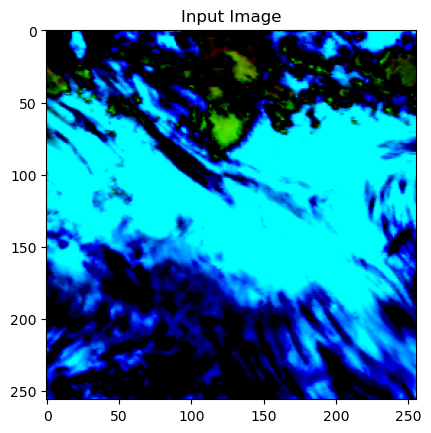

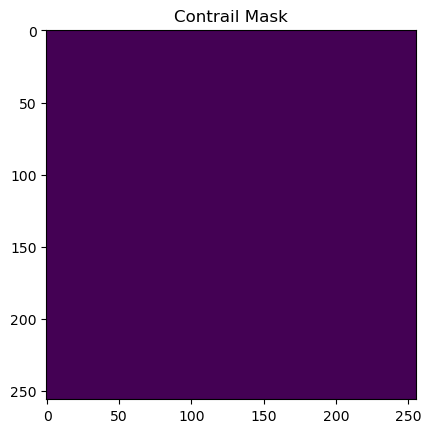

In [6]:
example_data = next(iter(data_loader_train))

print(f'Input shape: {example_data[0][:1].shape}, Output shape: {example_data[1][:1].shape}')

import matplotlib.pyplot as plt

plt.imshow(example_data[0][1].permute(1,2,0))
plt.title('Input Image')
plt.show()
plt.imshow(example_data[1][1])
plt.title('Contrail Mask')
plt.show()

In [7]:
# Model parameters
input_shape, output_shape = example_data[0][0].shape, example_data[1][0].shape
input_channels = 3
output_channels = 3
num_filters = [8,16, 32, 64, 128, 256, 512]
max_filters = 512  # Adjust input shape accordingly
kernel_sizes = [3, 3, 3, 3, 3, 3, 3]
strides = [2, 2, 2, 2, 2, 2, 3]  # Using strides for downsampling and upsampling
dropout_rate = 0.01
latent_dim = 512

In [8]:
def create_encoder_block(in_channels, out_channels, kernel_size, stride, dropout_rate, batch_norm=True, activation=nn.GELU()):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate),
        nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate),
        nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate),
        nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate)
    )
    return block

def create_decoder_block(in_channels, out_channels, kernel_size, stride, dropout_rate, batch_norm=True, activation=nn.GELU()):
    block = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size-1, stride=2, padding=0),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate),
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate),
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate),
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        activation,
        nn.Dropout(dropout_rate)
    )
    return block


In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dropout_rate, batch_norm=True, activation=nn.GELU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        x = self.activation(x) if self.activation else x
        x = self.dropout(x)
        return x


class TransposeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dropout_rate, batch_norm=True, activation=nn.GELU()):
        super(TransposeConvBlock, self).__init__()
        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size-1, stride=2, padding=0)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.convT(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        x = self.activation(x) if self.activation else x
        x = self.dropout(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_sizes, strides, dropout_rate):
        super(Encoder, self).__init__()
        self.blocks = nn.ModuleList([
            create_encoder_block(in_channels if i == 0 else num_filters[i-1], num_filters[i], kernel_sizes[i], strides[i], dropout_rate)
            for i in range(len(num_filters)-1)
        ])
        self.mean_block = create_encoder_block(num_filters[-2], num_filters[-1], kernel_sizes[-1], strides[-1], dropout_rate, activation=nn.Identity())
        self.std_block = create_encoder_block(num_filters[-2], num_filters[-1], kernel_sizes[-1], strides[-1], dropout_rate, activation=nn.Identity())
        self.avg_pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
        self.avg_pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
        
    def forward(self, x):
        skips = []
        for block in self.blocks:
            x = block(x)
#             print(f'Encoder Block {x.shape}')
            skips.append(x)
        x_mean = self.mean_block(x)
        x_std = torch.exp(0.5*self.std_block(x))
        x_mean = self.avg_pool1(x_mean)
        x_std = self.avg_pool2(x_std)
        return x_mean, x_std, skips


class Decoder(nn.Module):
    def __init__(self, out_channels, num_filters, kernel_sizes, strides, dropout_rate):
        super(Decoder, self).__init__()
        self.blocks = nn.ModuleList([
            create_decoder_block(num_filters[i]*2 if i < len(num_filters)-1 else num_filters[i], 
                               num_filters[i-1] if i > 0 else out_channels, 
                               kernel_sizes[i], strides[i], dropout_rate, activation=nn.GELU() if i<len(num_filters)-1 else nn.Sigmoid())
            for i in reversed(range(len(num_filters)))
        ])
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=num_filters[-1], out_channels=num_filters[-1], kernel_size=2, stride=2)
    def forward(self, x, skips):
        x = x.view(-1, x.shape[-1], 1, 1) 
#         print(x.shape)
        x = self.conv_transpose1(x)
#         print(f'{x.shape}\n')
        for i, block in enumerate(self.blocks):
#             print(f'Decoder Block In{i} - {x.shape}')
            x = block(x)
#             print(f'Decoder Block Out{i} - {x.shape}')
            if i < len(self.blocks) - 1:  # no skip connection for last block
#                 print(f'Decoder Skip {i} - {skips[-(i+1)].shape}')
                x = torch.cat([x, skips[-(i+1)]], dim=1)  # concatenate along channel dimension
#                 print(f'Decoder Concat {i} - {x.shape}\n')
        return x

    
class Model(nn.Module):
    def __init__(self, in_channels, out_channels, num_filters, kernel_sizes, strides, dropout_rate, smp_model):
        super(Model, self).__init__()
        self.encoder = Encoder(in_channels, num_filters, kernel_sizes, strides, dropout_rate)
        self.decoder = Decoder(out_channels, num_filters, kernel_sizes, strides, dropout_rate)
        self.smp_model = smp_model

    def forward(self, x):
        z_mean, z_std, skips = self.encoder(x)
#         print([skip.shape for skip in skips])
        shape = z_mean.shape
        z_mean, z_std = nn.Flatten()(z_mean), nn.Flatten()(z_std)
        posterior = MultivariateNormal(z_mean, scale_tril=torch.diag_embed(z_std))
        prior = MultivariateNormal(torch.zeros_like(z_mean), scale_tril=torch.diag_embed(torch.ones_like(z_std)))  # the prior, standard normal  
        kl = kl_divergence(posterior, prior).sum()
        z = posterior.sample()
        z.reshape(shape)
        decoded = self.decoder(z, skips)
        seg_out = self.smp_model(decoded)
#         out = nn.Sigmoid()(nn.ReLU()(seg_out)) 
        return seg_out, kl


In [10]:
# import torch
# from torch.distributions import Normal, kl_divergence, MultivariateNormal

# # Generate random Gaussian parameters for demonstration
# mu = torch.randn(5)  # one-dimensional tensor filled with normally distributed random numbers
# logvar = torch.randn(5)  # one-dimensional tensor filled with normally distributed random numbers
# std = torch.exp(0.5*logvar)
# # Create the Gaussian distributions
# posterior = MultivariateNormal(mu, scale_tril=torch.diag_embed(std))
# prior = MultivariateNormal(torch.zeros_like(mu), scale_tril=torch.diag_embed(torch.ones_like(std)))  # the prior, standard normal

# # Compute the KL divergence
# kl = kl_divergence(posterior, prior).sum()

# print("KL Divergence: ", kl.item())



In [11]:
input_sample = example_data[0][:1]
input_sample.shape

torch.Size([1, 3, 256, 256])

In [12]:
# model_vae = Model(input_channels, output_channels, num_filters, kernel_sizes, strides, dropout_rate)
# y_pred = model_vae(input_sample)
# y_pred.shape


In [13]:
# Lightning module
import torch
import torch.distributions as dist
import torch.nn.functional as F
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
import torch.nn as nn
from torchmetrics.functional import dice
# from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger


seg_models = {
#     "VAEUnet": Model(input_channels, output_channels, num_filters, kernel_sizes, strides, dropout_rate),
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}


class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.save_hyperparameters(config)
        try:
            model = seg_models[config["seg_model"]](
                                encoder_name=config["encoder_name"],
                                encoder_weights="imagenet",
                                in_channels=3,
                                classes=1,
                                activation=None)
            self.model = Model(input_channels, output_channels, num_filters, kernel_sizes, strides, dropout_rate, model)
#             print(self.model)
        except:
            self.model = seg_models[config['seg_model']]
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []
        self.val_step_imgs = []

    def forward(self, batch):
        imgs = batch
        preds, _ = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds, kl_loss = self.model(imgs)
        loss = self.loss_module(preds, labels)
        loss += kl_loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds, kl_loss = self.model(imgs)
        loss = self.loss_module(nn.ReLU()(preds), labels)
        loss += kl_loss
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)
        self.val_step_imgs.append(imgs)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_imgs = torch.cat(self.val_step_imgs)
        index = torch.randint(0, len(all_preds), (1,)).item()
        fig, axs = plt.subplots(1, 3,)  # create a figure with 3 subplots
        axs[0].imshow(all_preds[index][0].detach().to('cpu'), cmap='jet')
        axs[0].set_title(f"Pred: {self.measure_sparsity(all_preds[index][0].detach().to('cpu')):.2f} , {all_preds[index][0].detach().to('cpu').mean():.2f}")
        axs[1].imshow(all_labels[index].detach().to('cpu'), cmap='jet')
        axs[1].set_title(f"True: {self.measure_sparsity(all_labels[index].detach().to('cpu')):.2f} , {all_labels[index].detach().to('cpu').mean():.2f}")
        axs[2].imshow(all_imgs[index].detach().to('cpu').permute(1,2,0))
        axs[2].set_title('Input Image')
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        plt.suptitle(f"val_dice: {val_dice.item():.2f}", y=0.75)
        plt.tight_layout()
        plt.show()
        self.val_step_outputs = []
        self.val_step_labels = []
        self.val_step_imgs = []
        
    def measure_sparsity(self, image):
        # image: a binary image tensor where contrail is 1 and background is 0
        num_pixels = torch.numel(image)
        num_non_zero = torch.count_nonzero(image)
        sparsity = 1 - (num_non_zero / num_pixels)
        return sparsity.item()

filename = f"model_vae"

checkpoint_callback = ModelCheckpoint(
    monitor="val_dice",
    dirpath=config["output_dir"],
    mode="max",
    filename=filename,
    save_top_k=1,
    verbose=1,
)

progress_bar_callback = TQDMProgressBar(refresh_rate=config["progress_bar_refresh_rate"])

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)

logger = pl.loggers.CSVLogger("csv_log")

trainer = pl.Trainer(
                        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], 
                        logger=logger, 
                        **config["trainer"],
                    #     accumulate_grad_batches=4,
#                         precision=16,
#                         limit_val_batches=0.5,  # use only 10% of validation data
                    #     resume_from_checkpoint=os.path.join(config["output_dir"], filename+'.ckpt'),
                    )


In [14]:
try:
    # Load the state_dict from checkpoint
    checkpoint = torch.load(os.path.join(config["output_dir"], filename+'.ckpt'))
    state_dict = checkpoint['state_dict']
    print(checkpoint.keys())
    # Create a new model instance and load the state_dict
    model = LightningModule(config["model"])
    model.load_state_dict(state_dict)
    print('Checkpoint loaded')
except Exception as error:
    print(error)
    model = LightningModule(config["model"])


[Errno 2] No such file or directory: 'models/model_vae.ckpt'


In [15]:
config

{'data_path': '/kaggle/input/contrails-images-ash-color',
 'model': {'encoder_name': 'timm-resnest26d',
  'loss_smooth': 1.0,
  'optimizer_params': {'lr': 0.003, 'weight_decay': 0.0},
  'scheduler': {'name': 'CosineAnnealingLR',
   'params': {'CosineAnnealingLR': {'T_max': 3000,
     'eta_min': 1e-06,
     'last_epoch': -1},
    'ReduceLROnPlateau': {'factor': 0.31622776601,
     'mode': 'min',
     'patience': 4,
     'verbose': True}}},
  'seg_model': 'Unet'},
 'output_dir': 'models',
 'progress_bar_refresh_rate': 1,
 'seed': 42,
 'train_bs': 32,
 'trainer': {'enable_progress_bar': True,
  'max_epochs': 1000,
  'min_epochs': 1000},
 'valid_bs': 64,
 'workers': 2}

Sanity Checking: 0it [00:00, ?it/s]

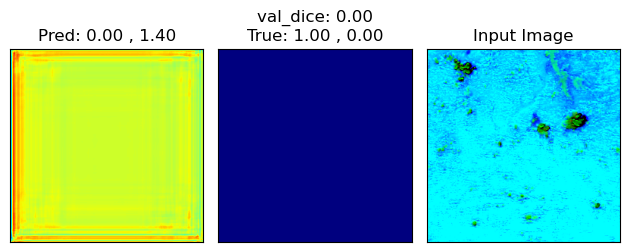

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

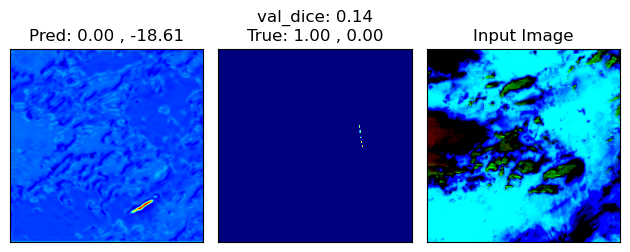

In [ ]:
trainer.fit(model, data_loader_train, data_loader_validation)

In [ ]:
y_pred = model(example_data[0][:1].to('cuda')).detach().to('cpu')
example_data[0][:1].shape

## Post-processing?
